In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [3]:
# Loading data
mort = pd.read_csv('../data/apache_patient_result_data.csv')
finGCS = pd.read_csv('../data/loaded/final_gcs.csv')
finGCS = finGCS.loc[:, ['patientunitstayid', 'Value']]
mort = mort.drop_duplicates('patientunitstayid')
mort['death'] = mort['actualhospitalmortality'] != 'ALIVE'
mort['los'] = mort['actualhospitallos'].astype(float)
mort = mort.loc[:, ['patientunitstayid', 'death', 'los']]
mort = mort.merge(finGCS, on = 'patientunitstayid', how = 'left')
mort = mort.dropna()
mort['GCS'] = mort['Value'] != 6
display(mort)

losAlive = mort[mort['death'] == False].loc[:, ['los']].values
losDeath = mort[mort['death'] == True].loc[:, ['los']].values
# plt.figure(figsize = (8, 8))
# plt.boxplot([losAlive, losDeath], labels = ["Alive", "Dead"])
# plt.xticks(size = 14)
# plt.yticks(size = 14)
# plt.ylabel("Length of ICU stay", size = 16)
# plt.title("Length of ICU Stay vs mortality", size = 16)
# plt.ylim((0, 25))
#plt.savefig("LOSvsMort.png", bbox_inches = 'tight')

# mort = mort[mort['death']]
display(mort)


los1 = mort[mort['Value'] == 1].loc[:, ['los']].values
los2 = mort[mort['Value'] == 2].loc[:, ['los']].values
los3 = mort[mort['Value'] == 3].loc[:, ['los']].values
los4 = mort[mort['Value'] == 4].loc[:, ['los']].values
los5 = mort[mort['Value'] == 5].loc[:, ['los']].values
los6 = mort[mort['Value'] == 6].loc[:, ['los']].values

# plt.figure(figsize = (8, 8))
# plt.boxplot([los1, los2, los3, los4, los5, los6], labels = ["1", "2", "3", "4", "5", "6"])
# plt.xticks(size = 14)
# plt.yticks(size = 14)
# plt.ylabel("Length of ICU stay", size = 16)
# plt.title("Length of ICU Stay vs final GCS", size = 16)
# plt.ylim((0, 35))
#plt.savefig("LOSvsGCS.png", bbox_inches = 'tight')

,patientunitstayid,death,los,Value,GCS
1,1015921,False,3.4118,6.0,False
2,1823818,False,4.7326,6.0,False
4,2228330,False,45.5549,2.0,True
5,3073401,False,9.9813,6.0,False
6,3199652,False,11.8257,6.0,False
...,...,...,...,...,...
4498,1451537,False,5.1590,6.0,False
4501,2712577,False,3.2410,6.0,False
4502,1791019,False,0.8715,6.0,False
4503,2263791,False,10.7319,6.0,False


,patientunitstayid,death,los,Value,GCS
1,1015921,False,3.4118,6.0,False
2,1823818,False,4.7326,6.0,False
4,2228330,False,45.5549,2.0,True
5,3073401,False,9.9813,6.0,False
6,3199652,False,11.8257,6.0,False
...,...,...,...,...,...
4498,1451537,False,5.1590,6.0,False
4501,2712577,False,3.2410,6.0,False
4502,1791019,False,0.8715,6.0,False
4503,2263791,False,10.7319,6.0,False


In [17]:
# Getting table of indicators for invasive measurements
invasive = pd.read_csv('../data/periodic_data.csv')
display(invasive)

,Unnamed: 0,patientunitstayid,diagnosisstring,vitalperiodicid,patientunitstayid.1,observationoffset,temperature,sao2,heartrate,respiration,cvp,etco2,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,st1,st2,st3,icp
0,0,2896749,neurologic|trauma - CNS|intracranial injury,1765692499,2896749,7698,NaN,97.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2896749,neurologic|trauma - CNS|intracranial injury,1743697627,2896749,6543,NaN,98.0,95.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2896749,neurologic|trauma - CNS|intracranial injury,1810334444,2896749,10318,NaN,98.0,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2896749,neurologic|trauma - CNS|intracranial injury,1719049881,2896749,2593,NaN,97.0,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2896749,neurologic|trauma - CNS|intracranial injury,1718466549,2896749,1508,NaN,98.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12666511,666511,962326,neurologic|trauma - CNS|intracranial injury|wi...,501613827,962326,1573,NaN,90.0,78.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,2.10,2.7,NaN
12666512,666512,911218,burns/trauma|trauma - CNS|intracranial injury|...,329743782,911218,7,NaN,62.0,67.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,0.70,0.3,NaN
12666513,666513,911218,burns/trauma|trauma - CNS|intracranial injury|...,329742951,911218,22,NaN,NaN,19.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12666514,666514,911218,burns/trauma|trauma - CNS|intracranial injury|...,329743504,911218,12,NaN,61.0,73.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.65,1.6,NaN


In [32]:
# Only keeping first 24 hours
invasive['offset'] = invasive['observationoffset'] / 60
invasive = invasive.loc[invasive['observationoffset'] <= 24*60]

feat_tokeep = ['icp', 'pamean', 'cvp', 'systemicmean']
invasive_grouped = invasive.groupby("patientunitstayid")[feat_tokeep].count()
invasive_grouped[invasive_grouped > 0] = 1
invasive_grouped = invasive_grouped.add_prefix("INVASIVE_")
display(invasive_grouped)

,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean
patientunitstayid,,,,
143094,0,0,0,0
143103,0,0,1,1
143274,0,0,0,0
144116,0,0,0,0
145396,1,0,0,1
...,...,...,...,...
3352294,0,0,0,0
3352295,0,0,0,0
3352531,0,0,0,0


In [4]:
# Settings
mort_features = False
los_features = False

In [33]:
# Gathering the rest of data
ap = pd.read_csv('../data/loaded/processed/aperiodic_processed.csv')
ap = ap.iloc[:, [0, 2, 3, 4]]
ap = ap.set_index('patientunitstayid').add_prefix("AP_")

dem = pd.read_csv('../data/loaded/processed/dem_processed.csv')
dem = dem.set_index('patientunitstayid').add_prefix("DEM_")

inf = pd.read_csv('../data/loaded/processed/infusion_processed.csv')
inf = inf.set_index('patientunitstayid').add_prefix("INF_")

lab = pd.read_csv('../data/loaded/processed/lab_processed.csv')
lab = lab.set_index('patientunitstayid').add_prefix("LAB_")

med = pd.read_csv('../data/loaded/processed/medication_processed.csv')
med = med.set_index('patientunitstayid').add_prefix("MED_")

resp_tb = pd.read_csv('../data/loaded/processed/respiratory_processed.csv')
resp_tb = resp_tb.set_index('patientunitstayid').add_prefix("RESP_")

nc = pd.read_csv('../data/loaded/processed/nc_processed.csv')
nc['verbal'][nc['verbal'] > 6] = 6
nc['eyes'][nc['eyes'] > 6] = 6
nc = nc.iloc[:, [0, 2, 3, 4]]
nc = nc.fillna(nc.mean())
nc = nc.set_index('patientunitstayid').add_prefix("NC_")

resp = pd.read_csv('../data/loaded/processed/respiratory_processed.csv')
pd.set_option('display.max_columns', None)
resp.iloc[:, 1:] = resp.iloc[:, 1:] > 0
resp['entries'] = resp.iloc[:, 1:].sum(axis = 1) > 0
resp = resp.iloc[:, [0, 27]]
resp = resp.set_index('patientunitstayid').add_prefix("resp_")

X_ts = pd.read_csv('../data/loaded/processed/ts_processed.csv')
X_hr = X_ts[['patientunitstayid', 'offset_bin', 'hr']].pivot(index='patientunitstayid',
            columns='offset_bin', values='hr').reset_index()
X_resp = X_ts[['patientunitstayid', 'offset_bin', 'resp']].pivot(index='patientunitstayid',
            columns='offset_bin', values='resp').reset_index()
X_sao2 = X_ts[['patientunitstayid', 'offset_bin', 'sao2']].pivot(index='patientunitstayid',
            columns='offset_bin', values='sao2').reset_index()
X_gcs = X_ts[['patientunitstayid', 'offset_bin', 'gcs']].pivot(index='patientunitstayid',
            columns='offset_bin', values='gcs').reset_index()
X_gcs.iloc[:, 1:][X_gcs.iloc[:, 1:] > 6] = 6
X_gcs.iloc[:, 1:][X_gcs.iloc[:, 1:] < 1] = 1

pca = PCA(n_components = 5)
hrp = pca.fit_transform(X_hr.iloc[:, 1:])
respp = pca.fit_transform(X_resp.iloc[:, 1:])

sao2p = pca.fit_transform(X_sao2.iloc[:, 1:])
# plt.figure(figsize = (8, 8))
# plt.title("sao2 PCA 0")
# plt.stem(pca.components_[0, :])

gcsp = pca.fit_transform(X_gcs.iloc[:, 1:])
# plt.figure(figsize = (8, 8))
# plt.title("GCS PCA 0")
# plt.stem(pca.components_[0, :])


hr = pd.DataFrame(hrp)
hr.columns = ['hr0', 'hr1', 'hr2', 'hr3', 'hr4']
hr['patientunitstayid'] = X_hr['patientunitstayid']

resp = pd.DataFrame(respp)
resp.columns = ['resp0', 'resp1', 'resp2', 'resp3', 'resp4']
resp['patientunitstayid'] = X_resp['patientunitstayid']

sao2 = pd.DataFrame(sao2p)
sao2.columns = ['sao20', 'sao21', 'sao22', 'sao23', 'sao24']
sao2['patientunitstayid'] = X_sao2['patientunitstayid']

gcs = pd.DataFrame(gcsp)
gcs.columns = ['gcs0', 'gcs1', 'gcs2', 'gcs3', 'gcs4']
gcs['patientunitstayid'] = X_gcs['patientunitstayid']

X = gcs.set_index('patientunitstayid').merge(hr.set_index('patientunitstayid'), how = 'left', left_index = True, right_index = True).merge(resp.set_index('patientunitstayid'), how = 'left',left_index = True, right_index = True).merge(sao2.set_index('patientunitstayid'), how = 'left',left_index = True, right_index = True)
Xn = X.merge(nc, how = 'left',left_index = True, right_index = True).merge(med,  how = 'left',left_index = True, right_index = True).merge(lab, how = 'left',left_index = True, right_index = True).merge(inf,  how = 'left',left_index = True, right_index = True).merge(dem,  how = 'left',left_index = True, right_index = True).merge(ap,  how = 'left',left_index = True, right_index = True).merge(resp_tb,  how = 'left',left_index = True, right_index = True).merge(invasive_grouped,  how = 'left',left_index = True, right_index = True)

# Mort Features
if mort_features:
    Xn = Xn[['DEM_age', 'gcs0', 'INF_norepinephrine','INF_morphine', 'LAB_BUN', 'LAB_glucose', 'sao20', 'INF_phenylephrine', 'MED_4846.0', 'LAB_paCO2']]

# LOS Features
elif los_features:
    Xn = Xn[['gcs0', 'MED_549.0', 'MED_2102.0', 'MED_1326.0', 'MED_25386.0', 'LAB_HCO3', 'LAB_Hct', 'LAB_O2 Sat (%)', 'LAB_Hgb', 'LAB_-lymphs']]

Xn = Xn.reset_index()

#out = GCS, los, death
out = "los"
Y = Xn.merge(mort)[out].values
Xns = Xn.merge(mort).iloc[:, :-4]
Xns = Xns.fillna(Xns.mean())
display(Y)
display(Xns)

X = Xns.drop('patientunitstayid', axis = 1).values
Xn = Xns.drop('patientunitstayid', axis = 1)

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([ 6.9319,  6.8625, 10.0014, ...,  7.6736, 14.9396,  4.1521])

,patientunitstayid,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,resp0,resp1,resp2,resp3,resp4,sao20,sao21,sao22,sao23,sao24,NC_verbal,NC_eyes,NC_temp,MED_89.0,MED_549.0,MED_610.0,MED_926.0,MED_1301.0,MED_1326.0,MED_1694.0,MED_1730.0,MED_1866.0,MED_2095.0,MED_2102.0,MED_4521.0,MED_4846.0,MED_8255.0,MED_19078.0,MED_20952.0,MED_22008.0,MED_25386.0,MED_33598.0,MED_35085.0,LAB_-basos,LAB_-eos,LAB_-lymphs,LAB_-monos,LAB_-polys,LAB_ALT (SGPT),LAB_AST (SGOT),LAB_BUN,LAB_Base Excess,LAB_FiO2,LAB_HCO3,LAB_Hct,LAB_Hgb,LAB_MCH,LAB_MCHC,LAB_MCV,LAB_MPV,LAB_O2 Sat (%),LAB_PT,LAB_PT - INR,LAB_PTT,LAB_RBC,LAB_RDW,LAB_WBC x 1000,LAB_albumin,LAB_alkaline phos.,LAB_anion gap,LAB_bedside glucose,LAB_bicarbonate,LAB_calcium,LAB_chloride,LAB_creatinine,LAB_glucose,LAB_magnesium,LAB_pH,LAB_paCO2,LAB_paO2,LAB_phosphate,LAB_platelets x 1000,LAB_potassium,LAB_sodium,LAB_total bilirubin,LAB_total protein,INF_fentanyl,INF_insulin,INF_midazolam,INF_morphine,INF_nicardipine,INF_norepinephrine,INF_phenylephrine,INF_propofol,INF_redbloodcell,INF_sodium,INF_vasopressin,DEM_age,DEM_admissionheight,DEM_admissionweight,DEM_gender,AP_sys,AP_dias,AP_bp,RESP_A1: High Exhaled Vt,RESP_B1: IPAP,RESP_B2: EPAP,RESP_B3: Est Mask Leak,RESP_CPAP,RESP_Compliance,RESP_ETCO2,RESP_Exhaled MV,RESP_Exhaled TV (machine),RESP_Exhaled TV (patient),RESP_FiO2,RESP_Flow Sensitivity,RESP_Humidifier Temp,RESP_LPM O2,RESP_Mean Airway Pressure,RESP_PEEP,RESP_PEEP/CPAP,RESP_Peak Flow,RESP_Peak Insp. Pressure,RESP_Plateau Pressure,RESP_Pressure Control,RESP_Pressure Support,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean
0,172448,21.395486,0.270489,0.140389,-0.132050,-0.127279,-6.178157,-33.565423,14.478608,6.298077,9.662249,-5.941014,-2.791059,4.270236,-4.158819,3.217790,0.664032,6.172689,-6.065612,0.335171,0.406836,1.000000,1.000000,97.50000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.00,0.00,8.00,10.00,82.00,27.25,27.25,24.5,7.0,80.00,30.0,31.9,11.15,30.2,35.1,86.0,27.25,27.25,27.25,27.25,27.25,3.71,18.80,12.2,27.25,27.25,8.5,128.800000,30.75,8.95,110.75,1.5725,129.0,2.20,7.5000,39.00,117.0,27.25,90.0,3.5375,146.75,27.25,27.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,177.80,96.40,1,147.000000,81.500000,108.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,0,1,1
1,242714,-3.097281,0.190085,-0.071351,-0.041548,0.014309,83.766630,-11.347911,2.104428,1.484181,2.998617,80.552517,17.688054,12.333048,13.062191,-7.330141,14.836540,-4.314695,1.254907,1.123629,0.035561,4.000000,4.000000,97.30000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40,0.10,11.30,9.10,78.50,11.00,16.00,14.0,12.6,12.60,12.6,36.1,12.00,32.2,33.2,96.8,12.60,12.60,15.90,1.20,12.60,3.73,12.60,10.8,4.00,51.00,11.0,122.000000,28.00,8.80,97.00,0.6000,131.0,12.60,12.6000,12.60,12.6,12.60,205.0,4.5000,136.00,1.00,6.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,182.90,89.20,1,126.760870,81.652174,98.695652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2,242825,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-10.112928,-10.793130,1.791435,-10.294386,-9.548700,18.659311,-12.257072,6.506917,-2.699845,2.174771,15.488906,0.039786,-1.278876,1.702754,-2.185273,3.882891,3.648673,79.19525,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.20,1.80,8.80,8.20,80.40,44.00,26.00,24.0,1.5,24.00,26.5,29.7,9.60,29.0,32.2,90.0,24.00,89.35,14.60,1.10,27.00,3.31,13.50,8.7,3.20,79.00,10.0,251.250000,27.00,8.20,101.00,0.8000,141.0,1.80,7.3800,46.00,63.0,24.00,142.0,4.7000,138.00,0.30,6.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,193.04,102.05,1,113.434783,58.434783,77.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
3,243176,-3.097281,0.190085,-

In [28]:
death = list(mort['death'])
los = list(mort['los'])
y = [(death[i], los[i]) for i in range(len(death))]
print(y)
print(pd.Series(y))

[(False, 3.4118), (False, 4.7326), (False, 45.5549), (False, 9.9813), (False, 11.8257), (False, 8.0104), (False, 2.7264), (False, 1.0625), (False, 22.3424), (False, 14.0375), (False, 28.8104), (False, 3.0167), (False, 13.6479), (False, 8.7438), (False, 46.8181), (False, 5.809), (False, 10.7319), (False, 4.4806), (False, 7.2986), (False, 7.8389), (True, 0.6549), (False, 2.4056), (False, 39.3347), (False, 3.466), (False, 14.7375), (False, 14.6986), (False, 5.7806), (True, 0.5646), (True, 0.7368), (True, 1.8715), (False, 14.9208), (False, 9.5521), (False, 1.0153), (False, 24.016), (True, 7.8694), (True, 23.5292), (False, 4.9292), (False, 5.0292), (False, 44.4854), (False, 10.7604), (False, 1.0056), (False, 1.4354), (False, 4.4799), (False, 6.1181), (False, 15.4625), (True, 1.3486), (False, 3.7917), (False, 32.7875), (True, 3.2417), (True, 39.5132), (False, 1.2813), (False, 28.1292), (True, 2.2986), (True, 1.3396), (False, 1.6549), (False, 2.4958), (False, 50.0), (False, 26.9313), (False, 

In [29]:
display(mort)
mort_surv_tble_forR = mort.copy()
newdeath = []
for d in death:
    if d == True:
        newdeath.append(1)
    else:
        newdeath.append(0)
mort_surv_tble_forR['death'] = newdeath
display(mort_surv_tble_forR)
mort_surv_tble_forR.to_csv('mort_surv_analysis_data.csv')

# Also creating inputs for LOS estimate
occurs = [1] * len(death)
los_tble_forR = mort.copy()
los_tble_forR['occurs'] = occurs
los_tble_forR = los_tble_forR.drop(columns=['death'])
display(los_tble_forR)
los_tble_forR.to_csv('los_surv_analysis_dat.csv')

,patientunitstayid,death,los,Value,GCS
1,1015921,False,3.4118,6.0,False
2,1823818,False,4.7326,6.0,False
4,2228330,False,45.5549,2.0,True
5,3073401,False,9.9813,6.0,False
6,3199652,False,11.8257,6.0,False
...,...,...,...,...,...
4498,1451537,False,5.1590,6.0,False
4501,2712577,False,3.2410,6.0,False
4502,1791019,False,0.8715,6.0,False
4503,2263791,False,10.7319,6.0,False


,patientunitstayid,death,los,Value,GCS
1,1015921,0,3.4118,6.0,False
2,1823818,0,4.7326,6.0,False
4,2228330,0,45.5549,2.0,True
5,3073401,0,9.9813,6.0,False
6,3199652,0,11.8257,6.0,False
...,...,...,...,...,...
4498,1451537,0,5.1590,6.0,False
4501,2712577,0,3.2410,6.0,False
4502,1791019,0,0.8715,6.0,False
4503,2263791,0,10.7319,6.0,False


,patientunitstayid,los,Value,GCS,occurs
1,1015921,3.4118,6.0,False,1
2,1823818,4.7326,6.0,False,1
4,2228330,45.5549,2.0,True,1
5,3073401,9.9813,6.0,False,1
6,3199652,11.8257,6.0,False,1
...,...,...,...,...,...
4498,1451537,5.1590,6.0,False,1
4501,2712577,3.2410,6.0,False,1
4502,1791019,0.8715,6.0,False,1
4503,2263791,10.7319,6.0,False,1


In [7]:
# Finding number who were alive by end of hospital stay
num_alive = sum([i == False for i in death])
num_dead = sum(death)

print("Num alive: %d" % num_alive)
print("Num dead: %d" % num_dead)

Num alive: 1902
Num dead: 308


Text(0.5, 1.0, 'Survival Curve for Patient Sample')

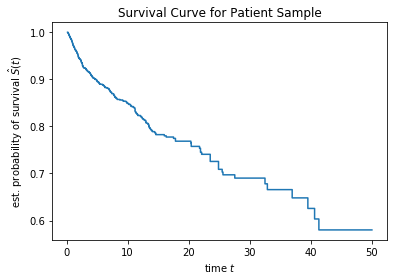

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(death, los)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Survival Curve for Patient Sample')

,patientunitstayid,death,los,Value,GCS
0,172448,True,6.9319,1.0,True
1,242714,False,6.8625,6.0,False
2,242825,False,10.0014,6.0,False
3,243176,False,6.5340,6.0,False
4,243493,False,2.5028,6.0,False
...,...,...,...,...,...
1684,3350835,False,6.0063,6.0,False
1685,3351268,False,8.2465,6.0,False
1686,3351909,False,7.6736,6.0,False
1687,3352618,False,14.9396,6.0,False


[20, 30, 40, 50, 60, 70, 80, 90, 100]


Text(0.5, 1.0, 'Survival Curves by Age')

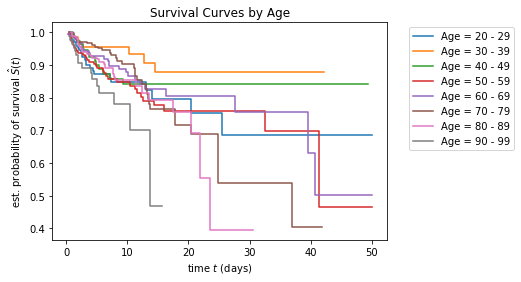

In [36]:
ages = list(range(20, 110, 10))
mort_filtered = pd.merge(Xns['patientunitstayid'], mort, how='inner')
display(mort_filtered)
death = list(mort_filtered['death'])
los = list(mort_filtered['los'])
print(ages)

for i in range(len(ages)-1):
    mask_treat_lower = list(Xns['DEM_age'] >= ages[i])
    mask_treat_upper = list(Xns['DEM_age'] < ages[i+1])
    mask_treat = [mask_treat_lower[i] and mask_treat_upper[i] for i in range(len(mask_treat_lower))]
    if sum(mask_treat) == 0:
        continue
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        np.array(death)[mask_treat],
        np.array(los)[mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Age = %s - %s" % (ages[i], ages[i+1]-1))

# plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (days)")
# plt.legend(loc ="best")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Survival Curves by Age')

,patientunitstayid,death,los,Value,GCS
0,172448,True,6.9319,1.0,True
1,242714,False,6.8625,6.0,False
2,242825,False,10.0014,6.0,False
3,243176,False,6.5340,6.0,False
4,243493,False,2.5028,6.0,False
...,...,...,...,...,...
1684,3350835,False,6.0063,6.0,False
1685,3351268,False,8.2465,6.0,False
1686,3351909,False,7.6736,6.0,False
1687,3352618,False,14.9396,6.0,False


[1, -1, 0]


Text(0.5, 1.0, 'Survival Curves by Gender')

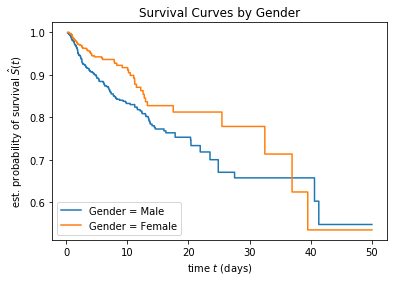

In [10]:
mort_filtered = pd.merge(Xns['patientunitstayid'], mort, how='inner')
genders = list(Xns['DEM_gender'].drop_duplicates())
display(mort_filtered)
death = list(mort_filtered['death'])
los = list(mort_filtered['los'])

print(genders)
for g in genders:
    mask_treat = list(Xns['DEM_gender'] == g)
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        np.array(death)[mask_treat],
        np.array(los)[mask_treat])
    if g == 1:
        label = "Male"
    elif g == -1:
        label = "Female"
    elif g == 0:
#         label = "Other"
        continue

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Gender = %s" % label)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (days)")
plt.legend(loc="lower left")
plt.title('Survival Curves by Gender')

In [34]:
mort_surv_tble_forR = pd.merge(Xns, mort, how='inner')
newdeath = []
for d in list(mort_surv_tble_forR['death']):
    if d == True:
        newdeath.append(1)
    else:
        newdeath.append(0)
mort_surv_tble_forR['death'] = newdeath
display(mort_surv_tble_forR)
mort_surv_tble_forR.to_csv('mort_surv_analysis_data.csv')

# Also creating inputs for LOS estimate
los_tble_forR = pd.merge(Xns, mort, how='inner')
occurs = [1] * los_tble_forR.shape[0]
los_tble_forR['occurs'] = occurs
los_tble_forR = los_tble_forR.drop(columns=['death'])
display(los_tble_forR)
los_tble_forR.to_csv('los_surv_analysis_dat.csv')

,patientunitstayid,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,resp0,resp1,resp2,resp3,resp4,sao20,sao21,sao22,sao23,sao24,NC_verbal,NC_eyes,NC_temp,MED_89.0,MED_549.0,MED_610.0,MED_926.0,MED_1301.0,MED_1326.0,MED_1694.0,MED_1730.0,MED_1866.0,MED_2095.0,MED_2102.0,MED_4521.0,MED_4846.0,MED_8255.0,MED_19078.0,MED_20952.0,MED_22008.0,MED_25386.0,MED_33598.0,MED_35085.0,LAB_-basos,LAB_-eos,LAB_-lymphs,LAB_-monos,LAB_-polys,LAB_ALT (SGPT),LAB_AST (SGOT),LAB_BUN,LAB_Base Excess,LAB_FiO2,LAB_HCO3,LAB_Hct,LAB_Hgb,LAB_MCH,LAB_MCHC,LAB_MCV,LAB_MPV,LAB_O2 Sat (%),LAB_PT,LAB_PT - INR,LAB_PTT,LAB_RBC,LAB_RDW,LAB_WBC x 1000,LAB_albumin,LAB_alkaline phos.,LAB_anion gap,LAB_bedside glucose,LAB_bicarbonate,LAB_calcium,LAB_chloride,LAB_creatinine,LAB_glucose,LAB_magnesium,LAB_pH,LAB_paCO2,LAB_paO2,LAB_phosphate,LAB_platelets x 1000,LAB_potassium,LAB_sodium,LAB_total bilirubin,LAB_total protein,INF_fentanyl,INF_insulin,INF_midazolam,INF_morphine,INF_nicardipine,INF_norepinephrine,INF_phenylephrine,INF_propofol,INF_redbloodcell,INF_sodium,INF_vasopressin,DEM_age,DEM_admissionheight,DEM_admissionweight,DEM_gender,AP_sys,AP_dias,AP_bp,RESP_A1: High Exhaled Vt,RESP_B1: IPAP,RESP_B2: EPAP,RESP_B3: Est Mask Leak,RESP_CPAP,RESP_Compliance,RESP_ETCO2,RESP_Exhaled MV,RESP_Exhaled TV (machine),RESP_Exhaled TV (patient),RESP_FiO2,RESP_Flow Sensitivity,RESP_Humidifier Temp,RESP_LPM O2,RESP_Mean Airway Pressure,RESP_PEEP,RESP_PEEP/CPAP,RESP_Peak Flow,RESP_Peak Insp. Pressure,RESP_Plateau Pressure,RESP_Pressure Control,RESP_Pressure Support,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean,death,los,Value,GCS
0,172448,21.395486,0.270489,0.140389,-0.132050,-0.127279,-6.178157,-33.565423,14.478608,6.298077,9.662249,-5.941014,-2.791059,4.270236,-4.158819,3.217790,0.664032,6.172689,-6.065612,0.335171,0.406836,1.000000,1.000000,97.50000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.00,0.00,8.00,10.00,82.00,27.25,27.25,24.5,7.0,80.00,30.0,31.9,11.15,30.2,35.1,86.0,27.25,27.25,27.25,27.25,27.25,3.71,18.80,12.2,27.25,27.25,8.5,128.800000,30.75,8.95,110.75,1.5725,129.0,2.20,7.5000,39.00,117.0,27.25,90.0,3.5375,146.75,27.25,27.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,177.80,96.40,1,147.000000,81.500000,108.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,0,1,1,1,6.9319,1.0,True
1,242714,-3.097281,0.190085,-0.071351,-0.041548,0.014309,83.766630,-11.347911,2.104428,1.484181,2.998617,80.552517,17.688054,12.333048,13.062191,-7.330141,14.836540,-4.314695,1.254907,1.123629,0.035561,4.000000,4.000000,97.30000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40,0.10,11.30,9.10,78.50,11.00,16.00,14.0,12.6,12.60,12.6,36.1,12.00,32.2,33.2,96.8,12.60,12.60,15.90,1.20,12.60,3.73,12.60,10.8,4.00,51.00,11.0,122.000000,28.00,8.80,97.00,0.6000,131.0,12.60,12.6000,12.60,12.6,12.60,205.0,4.5000,136.00,1.00,6.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,182.90,89.20,1,126.760870,81.652174,98.695652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,6.8625,6.0,False
2,242825,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-10.112928,-10.793130,1.791435,-10.294386,-9.548700,18.659311,-12.257072,6.506917,-2.699845,2.174771,15.488906,0.039786,-1.278876,1.702754,-2.185273,3.882891,3.648673,79.19525,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.20,1.80,8.80,8.20,80.40,44.00,26.00,24.0,1.5,24.00,26.5,29.7,9.60,29.0,32.2,90.0,24.00,89.35,14.60,1.10,27.00,3.31,13.50,8.7,3.20,79.00,10.0,251.250000,27.00,8.20,101.00,0.8000,141.0,1.80,7.3800,46.00,63.0,24.00,142.0,4.7000,138.00,0.30,6.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,193.04,102.05,1,113.434783,58.434783,77.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

,patientunitstayid,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,resp0,resp1,resp2,resp3,resp4,sao20,sao21,sao22,sao23,sao24,NC_verbal,NC_eyes,NC_temp,MED_89.0,MED_549.0,MED_610.0,MED_926.0,MED_1301.0,MED_1326.0,MED_1694.0,MED_1730.0,MED_1866.0,MED_2095.0,MED_2102.0,MED_4521.0,MED_4846.0,MED_8255.0,MED_19078.0,MED_20952.0,MED_22008.0,MED_25386.0,MED_33598.0,MED_35085.0,LAB_-basos,LAB_-eos,LAB_-lymphs,LAB_-monos,LAB_-polys,LAB_ALT (SGPT),LAB_AST (SGOT),LAB_BUN,LAB_Base Excess,LAB_FiO2,LAB_HCO3,LAB_Hct,LAB_Hgb,LAB_MCH,LAB_MCHC,LAB_MCV,LAB_MPV,LAB_O2 Sat (%),LAB_PT,LAB_PT - INR,LAB_PTT,LAB_RBC,LAB_RDW,LAB_WBC x 1000,LAB_albumin,LAB_alkaline phos.,LAB_anion gap,LAB_bedside glucose,LAB_bicarbonate,LAB_calcium,LAB_chloride,LAB_creatinine,LAB_glucose,LAB_magnesium,LAB_pH,LAB_paCO2,LAB_paO2,LAB_phosphate,LAB_platelets x 1000,LAB_potassium,LAB_sodium,LAB_total bilirubin,LAB_total protein,INF_fentanyl,INF_insulin,INF_midazolam,INF_morphine,INF_nicardipine,INF_norepinephrine,INF_phenylephrine,INF_propofol,INF_redbloodcell,INF_sodium,INF_vasopressin,DEM_age,DEM_admissionheight,DEM_admissionweight,DEM_gender,AP_sys,AP_dias,AP_bp,RESP_A1: High Exhaled Vt,RESP_B1: IPAP,RESP_B2: EPAP,RESP_B3: Est Mask Leak,RESP_CPAP,RESP_Compliance,RESP_ETCO2,RESP_Exhaled MV,RESP_Exhaled TV (machine),RESP_Exhaled TV (patient),RESP_FiO2,RESP_Flow Sensitivity,RESP_Humidifier Temp,RESP_LPM O2,RESP_Mean Airway Pressure,RESP_PEEP,RESP_PEEP/CPAP,RESP_Peak Flow,RESP_Peak Insp. Pressure,RESP_Plateau Pressure,RESP_Pressure Control,RESP_Pressure Support,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean,los,Value,GCS,occurs
0,172448,21.395486,0.270489,0.140389,-0.132050,-0.127279,-6.178157,-33.565423,14.478608,6.298077,9.662249,-5.941014,-2.791059,4.270236,-4.158819,3.217790,0.664032,6.172689,-6.065612,0.335171,0.406836,1.000000,1.000000,97.50000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.00,0.00,8.00,10.00,82.00,27.25,27.25,24.5,7.0,80.00,30.0,31.9,11.15,30.2,35.1,86.0,27.25,27.25,27.25,27.25,27.25,3.71,18.80,12.2,27.25,27.25,8.5,128.800000,30.75,8.95,110.75,1.5725,129.0,2.20,7.5000,39.00,117.0,27.25,90.0,3.5375,146.75,27.25,27.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,177.80,96.40,1,147.000000,81.500000,108.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,0,1,1,6.9319,1.0,True,1
1,242714,-3.097281,0.190085,-0.071351,-0.041548,0.014309,83.766630,-11.347911,2.104428,1.484181,2.998617,80.552517,17.688054,12.333048,13.062191,-7.330141,14.836540,-4.314695,1.254907,1.123629,0.035561,4.000000,4.000000,97.30000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40,0.10,11.30,9.10,78.50,11.00,16.00,14.0,12.6,12.60,12.6,36.1,12.00,32.2,33.2,96.8,12.60,12.60,15.90,1.20,12.60,3.73,12.60,10.8,4.00,51.00,11.0,122.000000,28.00,8.80,97.00,0.6000,131.0,12.60,12.6000,12.60,12.6,12.60,205.0,4.5000,136.00,1.00,6.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,182.90,89.20,1,126.760870,81.652174,98.695652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,6.8625,6.0,False,1
2,242825,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-10.112928,-10.793130,1.791435,-10.294386,-9.548700,18.659311,-12.257072,6.506917,-2.699845,2.174771,15.488906,0.039786,-1.278876,1.702754,-2.185273,3.882891,3.648673,79.19525,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.20,1.80,8.80,8.20,80.40,44.00,26.00,24.0,1.5,24.00,26.5,29.7,9.60,29.0,32.2,90.0,24.00,89.35,14.60,1.10,27.00,3.31,13.50,8.7,3.20,79.00,10.0,251.250000,27.00,8.20,101.00,0.8000,141.0,1.80,7.3800,46.00,63.0,24.00,142.0,4.7000,138.00,0.30,6.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,193.04,102.05,1,113.434783,58.434783,77.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [12]:
# Getting y values
mort_filtered = pd.merge(Xns['patientunitstayid'], mort, how='inner')
display(mort_filtered)
death = list(mort_filtered['death'])
los = list(mort_filtered['los'])

,patientunitstayid,death,los,Value,GCS
0,172448,True,6.9319,1.0,True
1,242714,False,6.8625,6.0,False
2,242825,False,10.0014,6.0,False
3,243176,False,6.5340,6.0,False
4,243493,False,2.5028,6.0,False
...,...,...,...,...,...
1684,3350835,False,6.0063,6.0,False
1685,3351268,False,8.2465,6.0,False
1686,3351909,False,7.6736,6.0,False
1687,3352618,False,14.9396,6.0,False


In [13]:
# Setting mode: mortality versus los
mort_pred = False
los_pred = True

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

assert(not (mort_pred and los_pred) and not (not mort_pred and not los_pred))
if mort_pred:
    y = np.array([(death[i], los[i]) for i in range(len(death))], dtype=[('Status', 'bool'), ('Survival_in_days', 'float')])
    yclass = np.array(death)
elif los_pred:
    y = np.array([(occurs[i], los[i]) for i in range(len(occurs))], dtype=[('Status', 'bool'), ('Survival_in_days', 'float')])
    yclass = np.array(occurs)

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.3, random_state=6)
trainpredsss = []
testpredsss = []
trainlabsss = []
testlabsss = []
i = 0

best_y_pred = []
best_concordance = 0

metrics = []
scaler = StandardScaler()
coefs = np.zeros((20, X.shape[1]))
for train_index, test_index in sss.split(X, yclass):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = CoxnetSurvivalAnalysis()
    model2 = CoxnetSurvivalAnalysis(fit_baseline_model=True)
    model.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    survival = model2.predict_survival_function(X_test)
    y_pred = model.predict(X_test)
    metric = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], y_pred)
    metrics.append(metric)
    if (metric[0] > best_concordance):
        best_concordance = metric[0]
        best_y_pred = y_pred
        
y_pred = best_y_pred

print('Best Concordance: ' + str(best_concordance))

concordances = [m[0] for m in metrics]
print('Average Concordance: ' + str(np.mean(concordances)))

C:\Users\owner\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anacon

C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_feat

Best Concordance: 0.689377991922783
Average Concordance: 0.6620030932369425


In [15]:
print(metrics)
print()
concordances = [m[0] for m in metrics]
print(np.mean(concordances))

[(0.6580697473160615, 84406, 43857, 0, 0), (0.6640782149038686, 85176, 43086, 0, 0), (0.6693018976781899, 85846, 42416, 0, 0), (0.6633634804303759, 85083, 43177, 0, 0), (0.689377991922783, 88421, 39841, 0, 0), (0.6760381094946282, 86710, 41552, 0, 0), (0.6643744834791286, 85214, 43048, 0, 0), (0.6604320809586552, 84709, 43554, 0, 0), (0.6602970412817214, 84693, 43572, 0, 0), (0.6611907249450326, 84803, 43455, 0, 0), (0.6771376667524306, 86849, 41410, 0, 0), (0.6807624839200094, 87318, 40947, 0, 0), (0.664078275445367, 85178, 43087, 0, 0), (0.6475444984134162, 83056, 45207, 0, 0), (0.6762798022797087, 86741, 41521, 0, 0), (0.6732859303612917, 86357, 41905, 0, 0), (0.67402642965735, 86454, 41811, 0, 0), (0.6733689889602694, 86369, 41895, 0, 0), (0.5276577995384519, 67121, 60026, 1117, 0), (0.6793962170001091, 87138, 41120, 0, 0)]

0.6620030932369425


4.5813
True


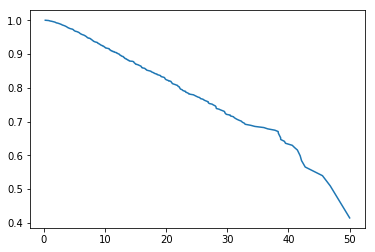

1.0944
True


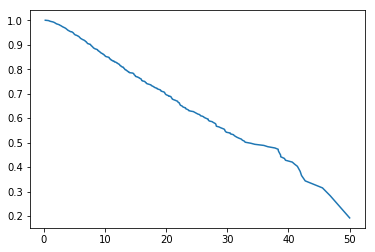

0.8313
True


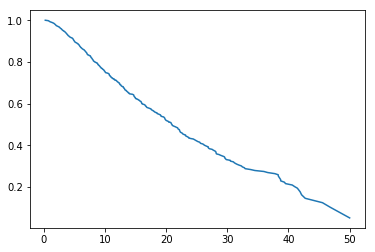

5.5306
True


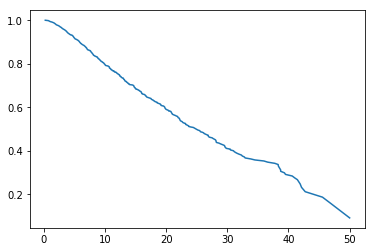

4.1549
True


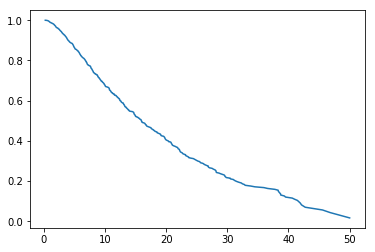

3.8326
True


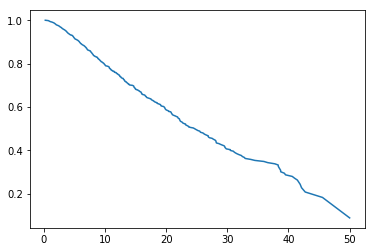

4.6889
True


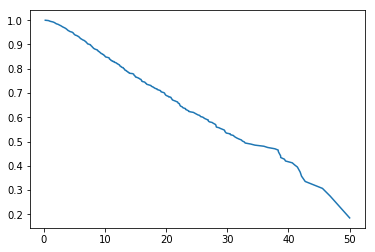

4.1701
True


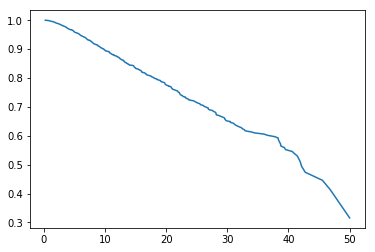

2.0889
True


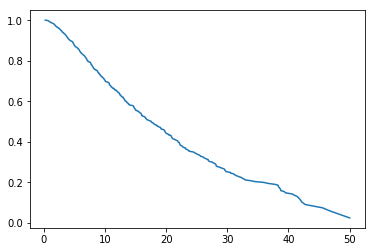

49.3194
True


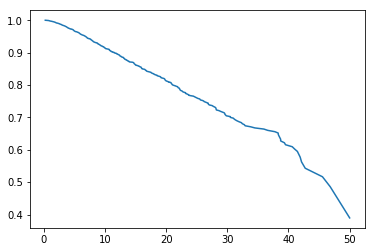

4.0653
True


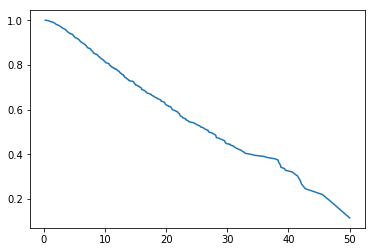

19.5097
True


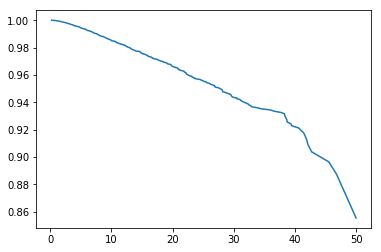

16.9729
True


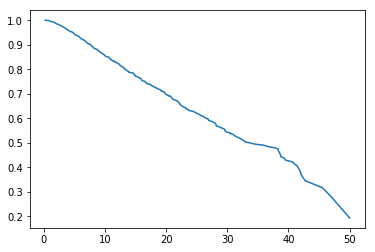

7.6285
True


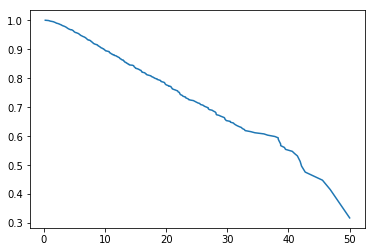

11.5375
True


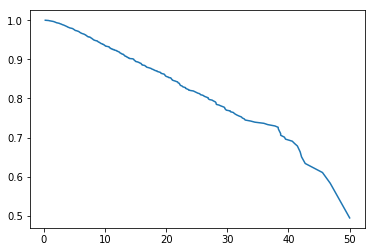

1.9194
True


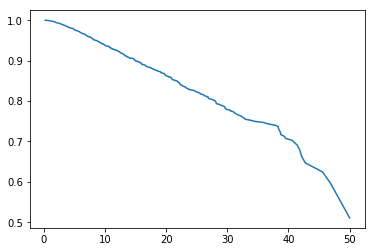

2.7792
True


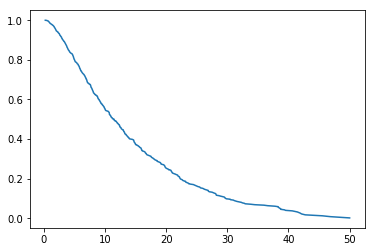

0.8333
True


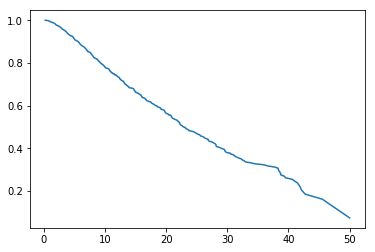

3.7333
True


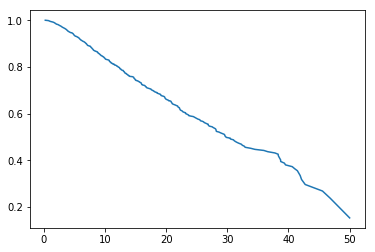

19.7243
True


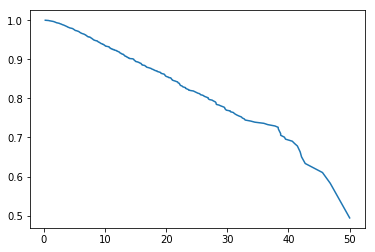

22.3424
True


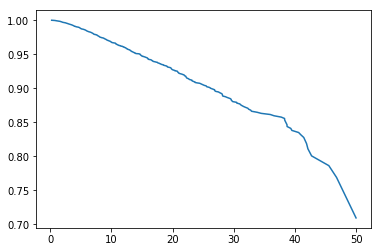

1.9625
True


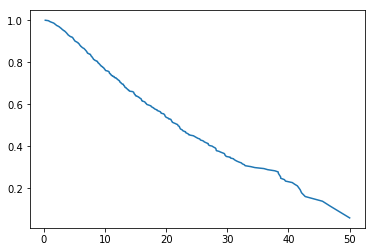

4.9271
True


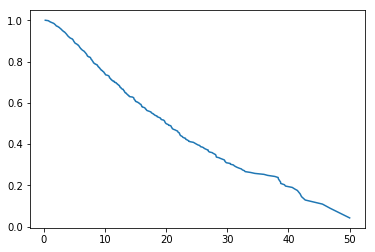

4.0743
True


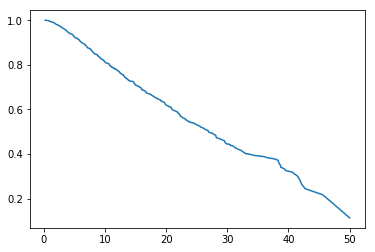

14.9208
True


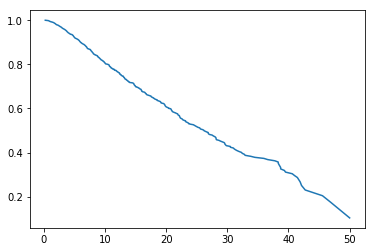

2.6313
True


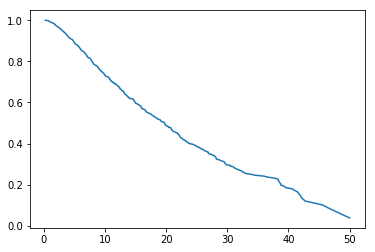

4.5917
True


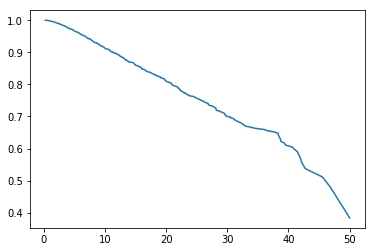

3.0292
True


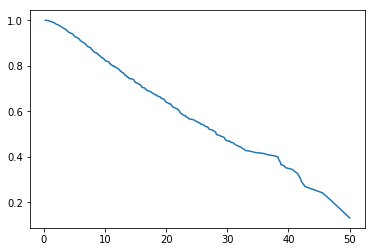

3.8806
True


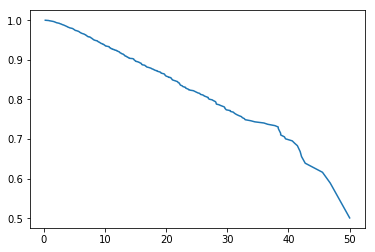

3.0139
True


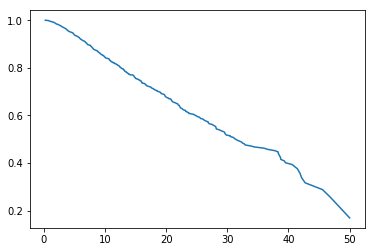

0.9
True


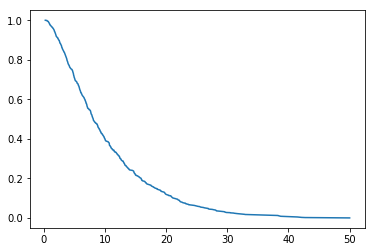

3.7931
True


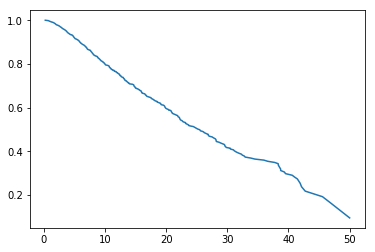

44.5451
True


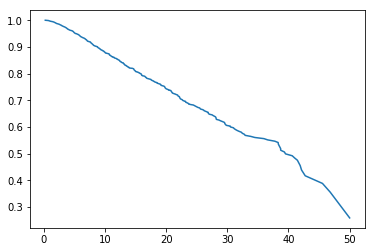

14.059000000000001
True


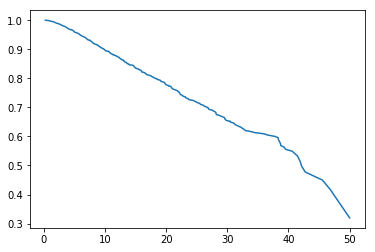

2.716
True


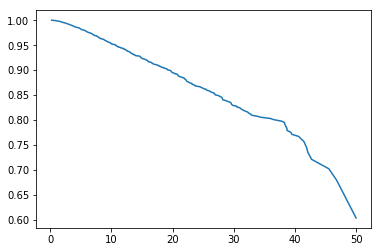

5.6160000000000005
True


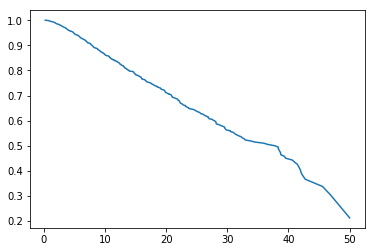

13.9743
True


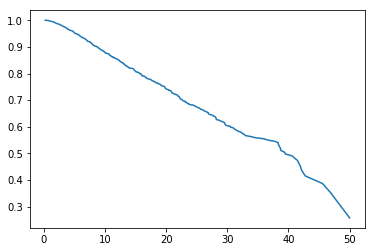

0.3271
True


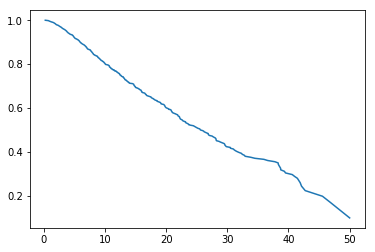

15.05
True


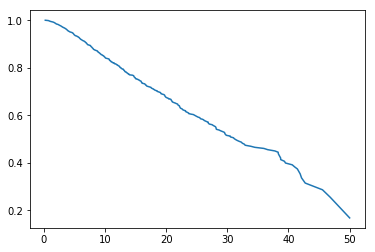

24.1014
True


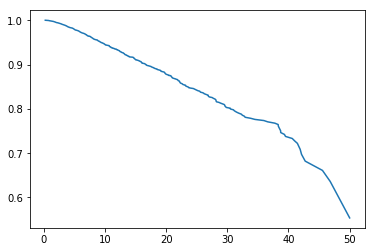

7.6694
True


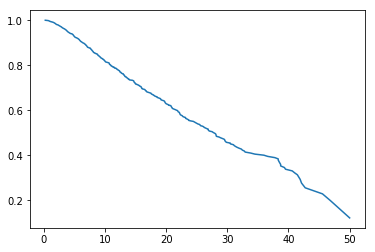

11.0292
True


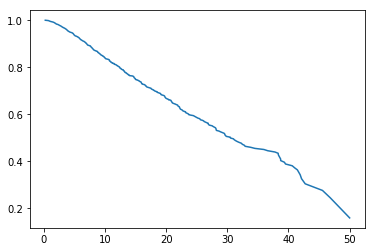

6.8951
True


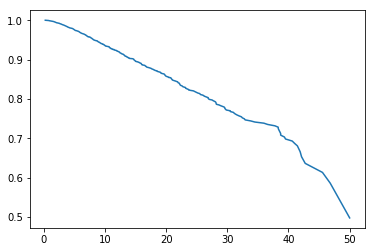

2.7861
True


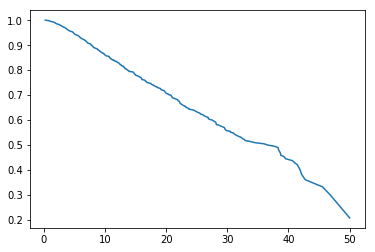

2.016
True


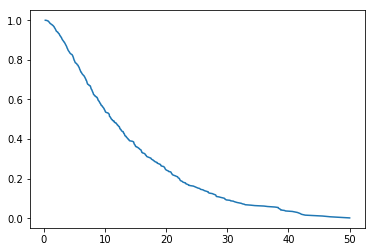

27.5493
True


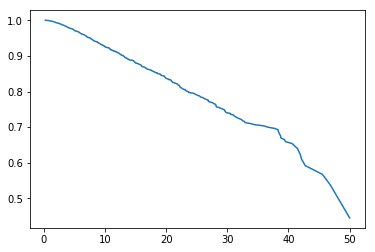

10.0326
True


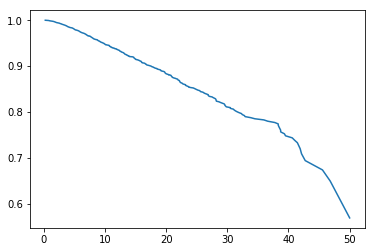

1.6556
True


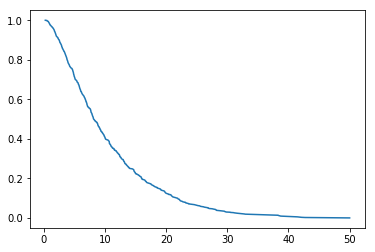

10.7458
True


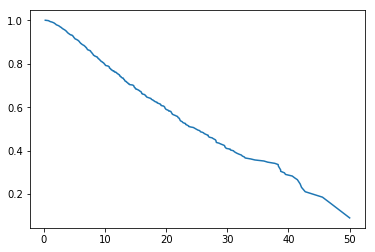

7.8326
True


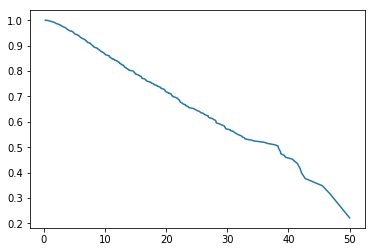

29.0833
True


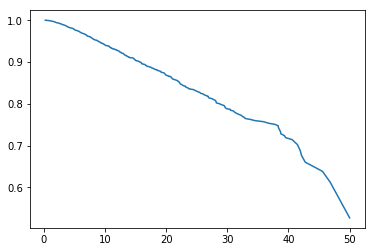

25.5382
True


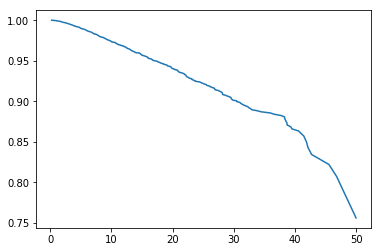

2.3924
True


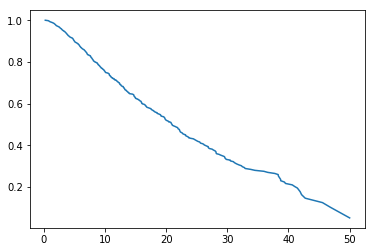

1.8833
True


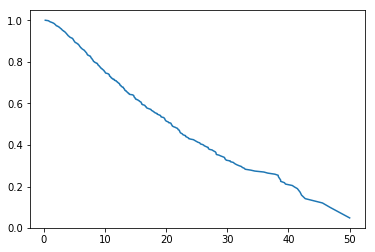

1.8375
True


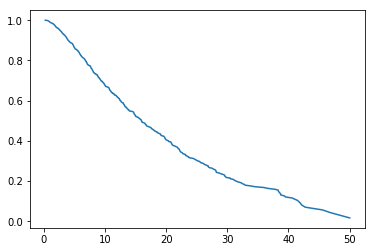

3.7938
True


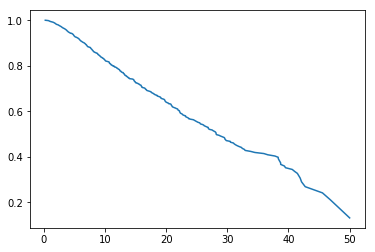

5.9764
True


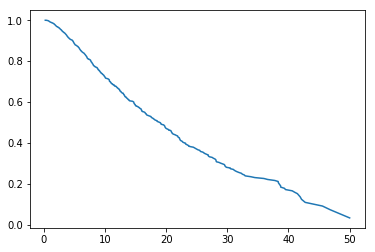

5.9549
True


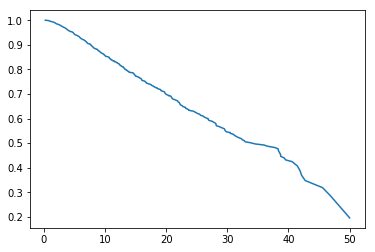

15.6285
True


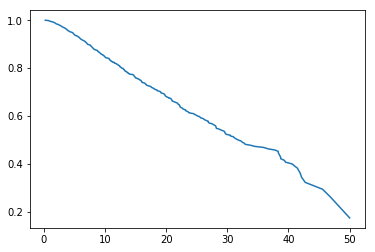

4.8583
True


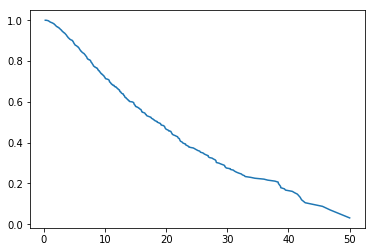

3.8292
True


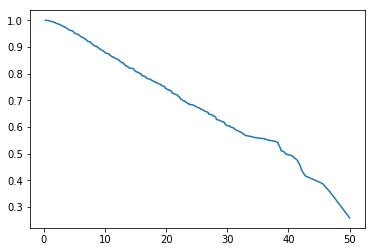

2.6681
True


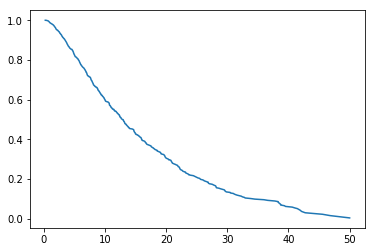

2.7597
True


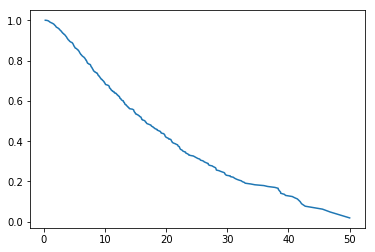

5.9639
True


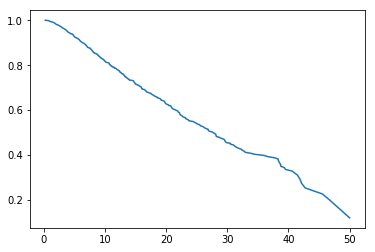

5.3972
True


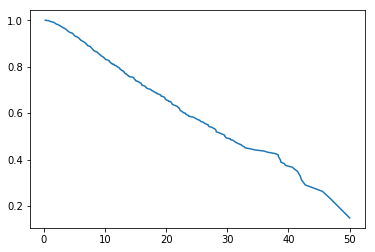

1.0125
True


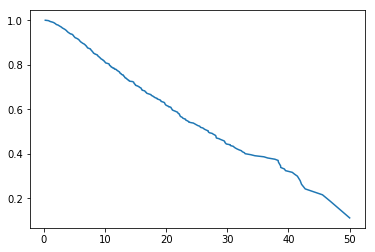

21.4681
True


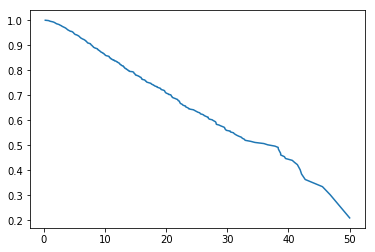

2.8847
True


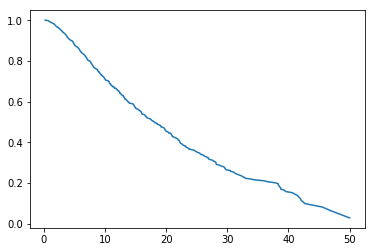

2.3069
True


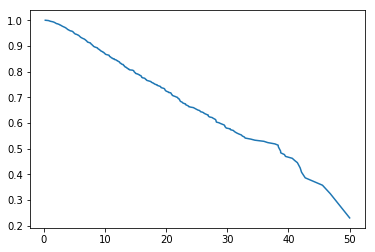

10.9236
True


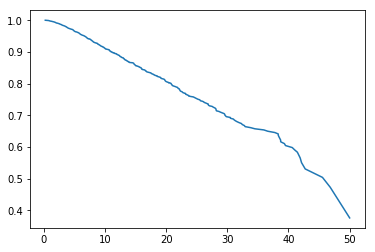

4.6576
True


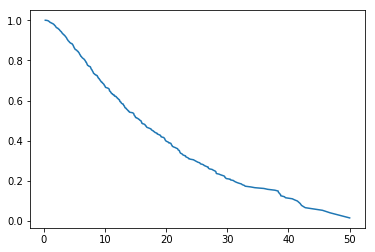

7.3701
True


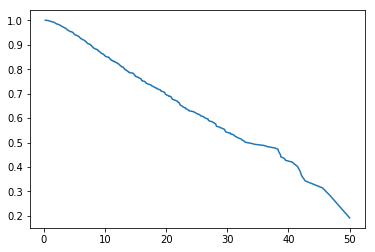

1.5965
True


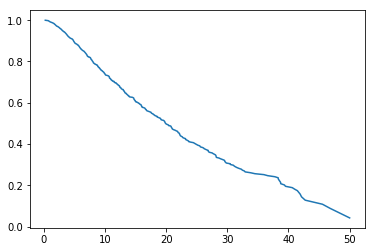

6.4514
True


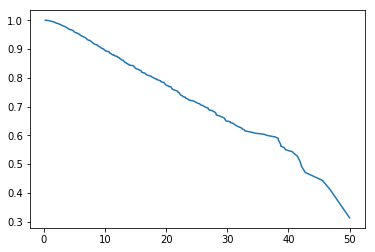

1.0583
True


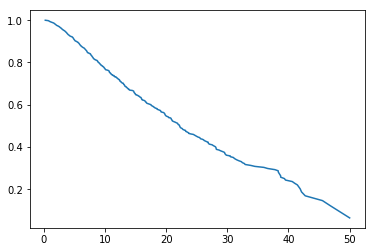

21.8028
True


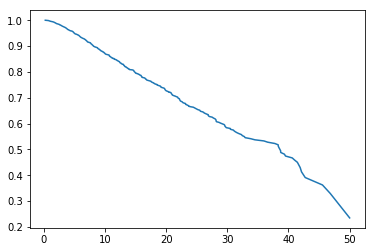

8.491
True


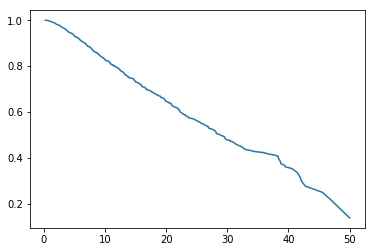

7.4417
True


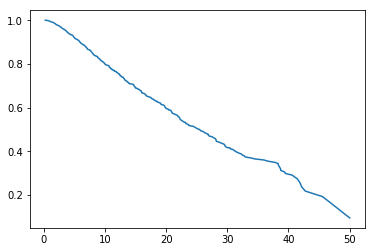

8.25
True


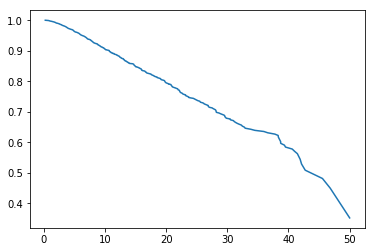

3.9965
True


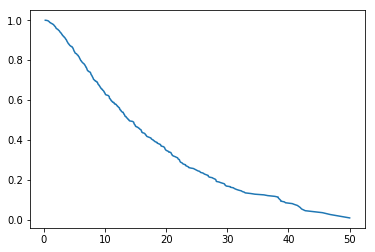

1.0847
True


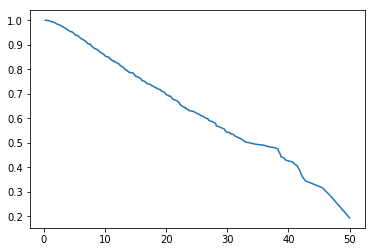

4.5007
True


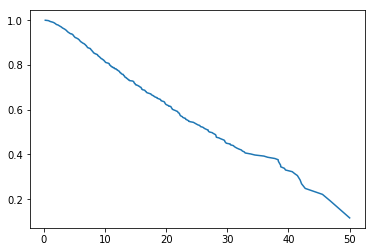

0.7736
True


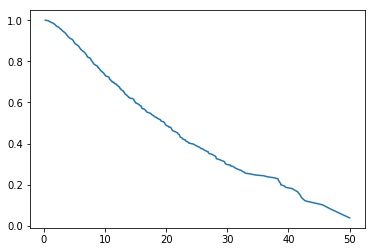

6.8889
True


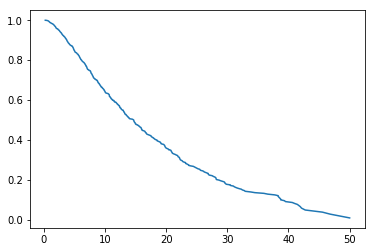

16.9333
True


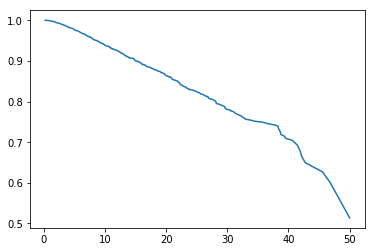

0.4764
True


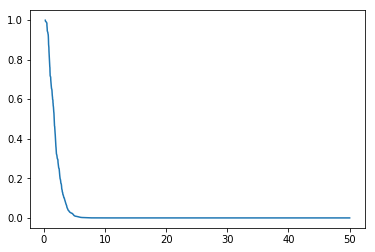

predict death
[3.3493]

13.6681
True


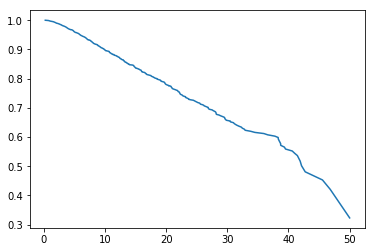

6.8839999999999995
True


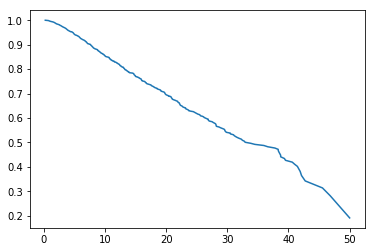

29.7229
True


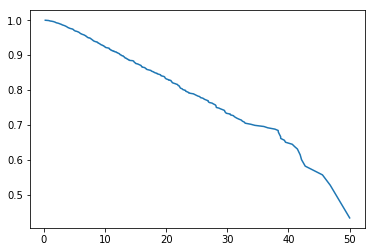

7.5014
True


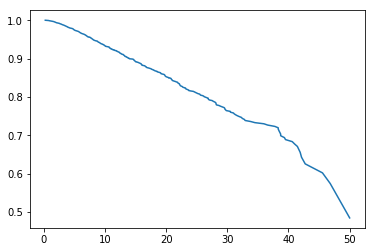

4.3118
True


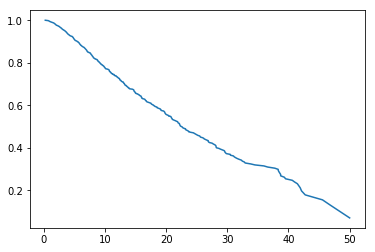

1.5111
True


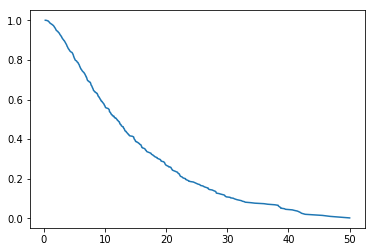

20.9604
True


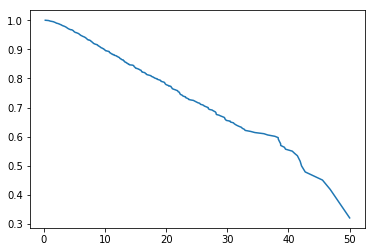

4.7556
True


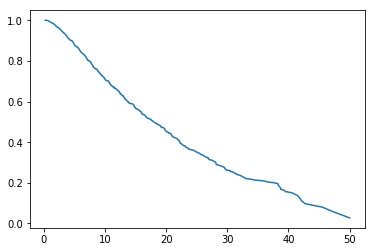

2.4667
True


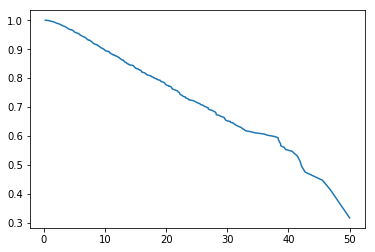

4.6167
True


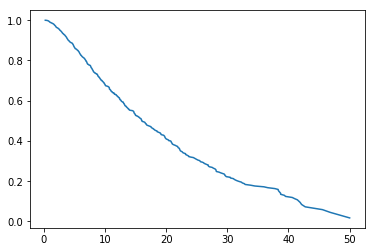

8.6785
True


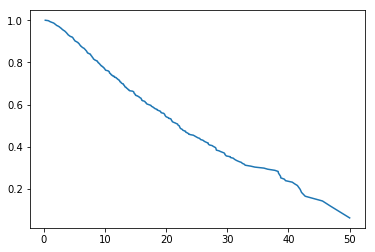

3.0049
True


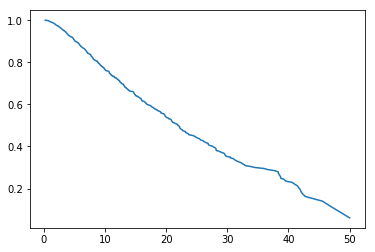

6.0125
True


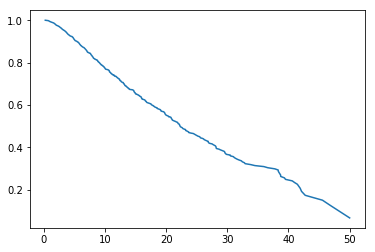

3.466
True


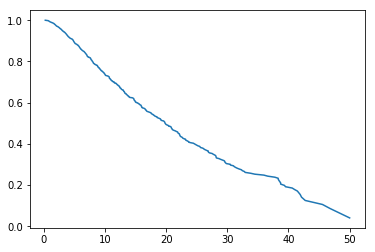

In [16]:
for i in range(100):
    print(y_test['Survival_in_days'][i])
    print(y_test['Status'][i])
    fun = survival[i]
    plt.figure()
    plt.plot(fun.x, fun.y)
    plt.show()
#     print(fun.y)
    
    minvaluey = min(fun.y)
    if (minvaluey < 1e-20):
        print('predict death')
        given_value = 0.1
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_idx = min(fun.y, key=absolute_difference_function)
        print(fun.x[fun.y == closest_idx])
        print()

# fun1 = survival[0]
# print(fun1)
# print(fun1.x)
# print(fun1.y)
# plt.plot(fun1.x, fun1.y)
# print(y_test['Survival_in_days'][0])

# fun1 = survival[1]
# print(fun1)
# print(fun1.x)
# print(fun1.y)
# plt.plot(fun1.x, fun1.y)
# print(y_test['Survival_in_days'][1])

In [17]:
from sksurv.metrics import concordance_index_censored
metric = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], y_pred)
print(metric)

(0.5084595112975409, 65214, 63044, 0, 0)


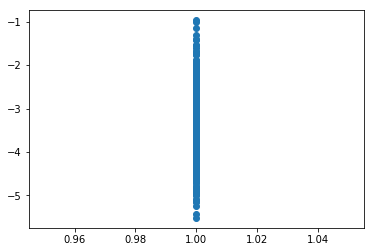

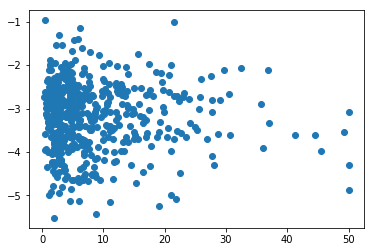

[-3.66100641 -2.10977487 -3.20056221 -2.60827104 -3.64335956 -2.53897001
 -3.12679275 -2.01865628 -3.27198283 -3.53694559 -2.23516338 -2.38799445
 -3.25500417 -2.40089905 -4.62826744 -3.08905222 -3.81374884 -2.37715012
 -2.32444797 -2.9754474  -2.83398937 -2.2996418  -4.64329648 -3.60394668
 -3.10676507 -3.88311546 -3.66291971 -2.03372784 -2.1908895  -2.75918906
 -2.82706369 -2.54596063 -3.59909968 -2.95874996 -4.15017786 -2.90263984
 -2.21425614 -2.7389596  -2.53728492 -3.34138126 -2.79810879 -3.51098365
 -3.82988963 -3.2105383  -2.94372819 -2.25850442 -4.1890561  -3.36895642
 -2.84799469 -3.2124342  -2.7923531  -3.00238082 -3.60186714 -3.28199462
 -3.19525305 -3.16245412 -2.66425598 -2.82917821 -3.69852559 -3.92560801
 -3.893456   -2.64852239 -2.88856379 -4.68467419 -1.88632786 -3.31633897
 -3.71145226 -3.44228463 -3.3542188  -2.44017105 -4.84815754 -3.85482858
 -4.26204757 -3.70437023 -4.99351535 -5.0812261  -4.344244   -2.71138382
 -3.43634645 -3.09228101 -2.39941936 -2.80226278 -2

In [18]:
plt.figure()
# print(y_test['Status'])
plt.plot(y_test['Status'], y_pred, 'o')
plt.show()

plt.figure()
plt.plot(y_test['Survival_in_days'], y_pred, 'o')
plt.show()

print(y_pred)

In [19]:
# For other survival models that do not rely on the proportional hazards assumption, 
# it is often impossible to estimate survival or cumulative hazard function. Their 
# predictions are risk scores of arbitrary scale. If samples are ordered according 
# to their predicted risk score (in ascending order), one obtains the sequence of 
# events, as predicted by the model. This is the return value of the predict() method
# of all survival models in scikit-survival.


# Ranking the risk scores in ascending order
pred_ranks = np.argsort(y_pred)
print(pred_ranks)

test_ranks = np.argsort(-1*y_test['Survival_in_days'])
print(test_ranks)

[128 263 292 309 262 289  75  74  92 118 404 460  70 332 315 303  63  89
 367 504 138  22 319  14 189 379 275 299 260 407 144  96 423 386 241 457
 210 334 499 141 188 489 161  76 396 454 347 137 272 365 111 335 207  72
 318 346 169 430 479 344  97  46 453 114  34 172 506 105 338 497 249 278
 284 342 170 200 162 175 307 383 428 438 437 183 267 456 308 371 180  59
 410 368 352 146  60 148 343  25 297 465  71  93 484 100  42 274 184 109
 391  16 218 176 232 178 179 108 458 382 220 387 158 449 491 477  87  66
 406 149 345  73  58 337 323 363 245  26 145 419   0 287 132 472 312   4
 443 451 475 196 398 195 384  23  52  32 450 445 153 291 215 119 168 246
 481 442   9 355 321 354  41 310  90 408 154 238 340 394 261 281 378  67
 122  78 227 402 113 224 151 133 495 388 214 209 339 186 341 285 336 282
 501 185 211  47 166  68  39  98 244 316 242 320 487  65 270 298 201 255
  53 264   8 411 198 177 157  12 470 250 328  49  43 110 500 202 372   2
  54 425  94 452 311 107 187 498  55 300 253 213 23

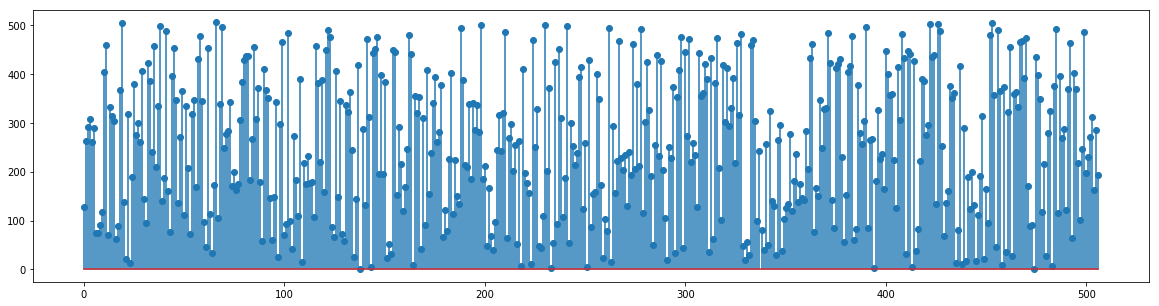

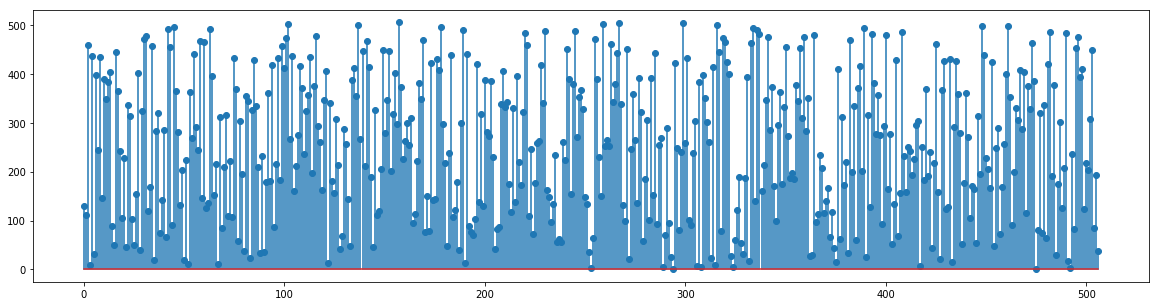

In [20]:
plt.figure(figsize=(20,5))
plt.stem(pred_ranks)
plt.show()

plt.figure(figsize=(20,5))
plt.stem(test_ranks)
plt.show()

Text(0, 0.5, 'Predicted Risk Score')

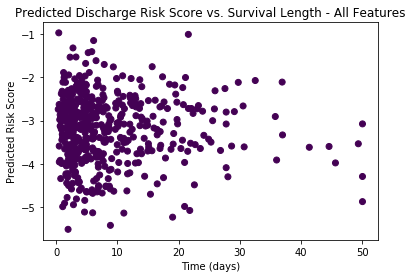

In [21]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

y_pred_scaled = scaler1.fit_transform(y_pred.reshape(-1, 1))
y_test_scaled = scaler2.fit_transform(y_test['Survival_in_days'].reshape(-1, 1))

plt.figure()
# plt.scatter(y_test['Survival_in_days'], y_pred, c=[not i for i in y_test['Status']])
plt.scatter(y_test['Survival_in_days'], y_pred, c=y_test['Status'])
if mort_pred:
    classes = ListedColormap(['Death','Survival'])
    plt.colorbar() # 1 (Death) is yellow, 0 (Survival) is purple
    title = 'Predicted Death Risk Score vs. Survival Length'
elif los_pred:
    title = 'Predicted Discharge Risk Score vs. Length of Stay'
    
if mort_features:
    plt.title(title + ' - Mort Features')
elif los_features:
    plt.title(title + ' - LOS Features')
else:
    plt.title(title + ' - All Features')
plt.xlabel('Time (days)')
plt.ylabel('Predicted Risk Score')

# Random Survival Forest

In [29]:
# Loading data
mort = pd.read_csv('../data/apache_patient_result_data.csv')
finGCS = pd.read_csv('../data/loaded/final_gcs.csv')
finGCS = finGCS.loc[:, ['patientunitstayid', 'Value']]
mort = mort.drop_duplicates('patientunitstayid')
mort['death'] = mort['actualhospitalmortality'] != 'ALIVE'
mort['los'] = mort['actualhospitallos'].astype(float)
mort = mort.loc[:, ['patientunitstayid', 'death', 'los']]
mort = mort.merge(finGCS, on = 'patientunitstayid', how = 'left')
mort = mort.dropna()
mort['GCS'] = mort['Value'] != 6
# display(mort)

losAlive = mort[mort['death'] == False].loc[:, ['los']].values
losDeath = mort[mort['death'] == True].loc[:, ['los']].values
# plt.figure(figsize = (8, 8))
# plt.boxplot([losAlive, losDeath], labels = ["Alive", "Dead"])
# plt.xticks(size = 14)
# plt.yticks(size = 14)
# plt.ylabel("Length of ICU stay", size = 16)
# plt.title("Length of ICU Stay vs mortality", size = 16)
# plt.ylim((0, 25))
#plt.savefig("LOSvsMort.png", bbox_inches = 'tight')

# mort = mort[mort['death']]
# display(mort)


los1 = mort[mort['Value'] == 1].loc[:, ['los']].values
los2 = mort[mort['Value'] == 2].loc[:, ['los']].values
los3 = mort[mort['Value'] == 3].loc[:, ['los']].values
los4 = mort[mort['Value'] == 4].loc[:, ['los']].values
los5 = mort[mort['Value'] == 5].loc[:, ['los']].values
los6 = mort[mort['Value'] == 6].loc[:, ['los']].values

# plt.figure(figsize = (8, 8))
# plt.boxplot([los1, los2, los3, los4, los5, los6], labels = ["1", "2", "3", "4", "5", "6"])
# plt.xticks(size = 14)
# plt.yticks(size = 14)
# plt.ylabel("Length of ICU stay", size = 16)
# plt.title("Length of ICU Stay vs final GCS", size = 16)
# plt.ylim((0, 35))
#plt.savefig("LOSvsGCS.png", bbox_inches = 'tight')

In [30]:
# Settings
mort_features = False
los_features = False

In [31]:
# Gathering the rest of data
ap = pd.read_csv('../data/loaded/processed/aperiodic_processed.csv')
ap = ap.iloc[:, [0, 2, 3, 4]]
ap = ap.set_index('patientunitstayid').add_prefix("AP_")

dem = pd.read_csv('../data/loaded/processed/dem_processed.csv')
dem = dem.set_index('patientunitstayid').add_prefix("DEM_")

inf = pd.read_csv('../data/loaded/processed/infusion_processed.csv')
inf = inf.set_index('patientunitstayid').add_prefix("INF_")

lab = pd.read_csv('../data/loaded/processed/lab_processed.csv')
lab = lab.set_index('patientunitstayid').add_prefix("LAB_")

med = pd.read_csv('../data/loaded/processed/medication_processed.csv')
med = med.set_index('patientunitstayid').add_prefix("MED_")

nc = pd.read_csv('../data/loaded/processed/nc_processed.csv')
nc['verbal'][nc['verbal'] > 6] = 6
nc['eyes'][nc['eyes'] > 6] = 6
nc = nc.iloc[:, [0, 2, 3, 4]]
nc = nc.fillna(nc.mean())
nc = nc.set_index('patientunitstayid').add_prefix("NC_")

resp = pd.read_csv('../data/loaded/processed/respiratory_processed.csv')
pd.set_option('display.max_columns', None)
resp.iloc[:, 1:] = resp.iloc[:, 1:] > 0
resp['entries'] = resp.iloc[:, 1:].sum(axis = 1) > 0
resp = resp.iloc[:, [0, 27]]
resp = resp.set_index('patientunitstayid').add_prefix("resp_")

X_ts = pd.read_csv('../data/loaded/processed/ts_processed.csv')
X_hr = X_ts[['patientunitstayid', 'offset_bin', 'hr']].pivot(index='patientunitstayid',
            columns='offset_bin', values='hr').reset_index()
X_resp = X_ts[['patientunitstayid', 'offset_bin', 'resp']].pivot(index='patientunitstayid',
            columns='offset_bin', values='resp').reset_index()
X_sao2 = X_ts[['patientunitstayid', 'offset_bin', 'sao2']].pivot(index='patientunitstayid',
            columns='offset_bin', values='sao2').reset_index()
X_gcs = X_ts[['patientunitstayid', 'offset_bin', 'gcs']].pivot(index='patientunitstayid',
            columns='offset_bin', values='gcs').reset_index()
X_gcs.iloc[:, 1:][X_gcs.iloc[:, 1:] > 6] = 6
X_gcs.iloc[:, 1:][X_gcs.iloc[:, 1:] < 1] = 1

pca = PCA(n_components = 5)
hrp = pca.fit_transform(X_hr.iloc[:, 1:])
respp = pca.fit_transform(X_resp.iloc[:, 1:])

sao2p = pca.fit_transform(X_sao2.iloc[:, 1:])
# plt.figure(figsize = (8, 8))
# plt.title("sao2 PCA 0")
# plt.stem(pca.components_[0, :])

gcsp = pca.fit_transform(X_gcs.iloc[:, 1:])
# plt.figure(figsize = (8, 8))
# plt.title("GCS PCA 0")
# plt.stem(pca.components_[0, :])


hr = pd.DataFrame(hrp)
hr.columns = ['hr0', 'hr1', 'hr2', 'hr3', 'hr4']
hr['patientunitstayid'] = X_hr['patientunitstayid']

resp = pd.DataFrame(respp)
resp.columns = ['resp0', 'resp1', 'resp2', 'resp3', 'resp4']
resp['patientunitstayid'] = X_resp['patientunitstayid']

sao2 = pd.DataFrame(sao2p)
sao2.columns = ['sao20', 'sao21', 'sao22', 'sao23', 'sao24']
sao2['patientunitstayid'] = X_sao2['patientunitstayid']

gcs = pd.DataFrame(gcsp)
gcs.columns = ['gcs0', 'gcs1', 'gcs2', 'gcs3', 'gcs4']
gcs['patientunitstayid'] = X_gcs['patientunitstayid']

X = gcs.set_index('patientunitstayid').merge(hr.set_index('patientunitstayid'), how = 'left', left_index = True, right_index = True).merge(resp.set_index('patientunitstayid'), how = 'left',left_index = True, right_index = True).merge(sao2.set_index('patientunitstayid'), how = 'left',left_index = True, right_index = True)
Xn = X.merge(nc, how = 'left',left_index = True, right_index = True).merge(med,  how = 'left',left_index = True, right_index = True).merge(lab, how = 'left',left_index = True, right_index = True).merge(inf,  how = 'left',left_index = True, right_index = True).merge(dem,  how = 'left',left_index = True, right_index = True).merge(ap,  how = 'left',left_index = True, right_index = True)

# Mort Features
if mort_features:
    Xn = Xn[['DEM_age', 'gcs0', 'INF_norepinephrine','INF_morphine', 'LAB_BUN', 'LAB_glucose', 'sao20', 'INF_phenylephrine', 'MED_4846.0', 'LAB_paCO2']]

# LOS Features
elif los_features:
    Xn = Xn[['gcs0', 'MED_549.0', 'MED_2102.0', 'MED_1326.0', 'MED_25386.0', 'LAB_HCO3', 'LAB_Hct', 'LAB_O2 Sat (%)', 'LAB_Hgb', 'LAB_-lymphs']]

Xn = Xn.reset_index()

#out = GCS, los, death
out = "los"
Y = Xn.merge(mort)[out].values
Xns = Xn.merge(mort).iloc[:, :-4]
Xns = Xns.fillna(Xns.mean())
display(Y)
display(Xns)

X = Xns.drop('patientunitstayid', axis = 1).values
Xn = Xns.drop('patientunitstayid', axis = 1)

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([ 6.9319,  6.8625, 10.0014, ...,  7.6736, 14.9396,  4.1521])

,patientunitstayid,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,resp0,resp1,resp2,resp3,resp4,sao20,sao21,sao22,sao23,sao24,NC_verbal,NC_eyes,NC_temp,MED_89.0,MED_549.0,MED_610.0,MED_926.0,MED_1301.0,MED_1326.0,MED_1694.0,MED_1730.0,MED_1866.0,MED_2095.0,MED_2102.0,MED_4521.0,MED_4846.0,MED_8255.0,MED_19078.0,MED_20952.0,MED_22008.0,MED_25386.0,MED_33598.0,MED_35085.0,LAB_-basos,LAB_-eos,LAB_-lymphs,LAB_-monos,LAB_-polys,LAB_ALT (SGPT),LAB_AST (SGOT),LAB_BUN,LAB_Base Excess,LAB_FiO2,LAB_HCO3,LAB_Hct,LAB_Hgb,LAB_MCH,LAB_MCHC,LAB_MCV,LAB_MPV,LAB_O2 Sat (%),LAB_PT,LAB_PT - INR,LAB_PTT,LAB_RBC,LAB_RDW,LAB_WBC x 1000,LAB_albumin,LAB_alkaline phos.,LAB_anion gap,LAB_bedside glucose,LAB_bicarbonate,LAB_calcium,LAB_chloride,LAB_creatinine,LAB_glucose,LAB_magnesium,LAB_pH,LAB_paCO2,LAB_paO2,LAB_phosphate,LAB_platelets x 1000,LAB_potassium,LAB_sodium,LAB_total bilirubin,LAB_total protein,INF_fentanyl,INF_insulin,INF_midazolam,INF_morphine,INF_nicardipine,INF_norepinephrine,INF_phenylephrine,INF_propofol,INF_redbloodcell,INF_sodium,INF_vasopressin,DEM_age,DEM_admissionheight,DEM_admissionweight,DEM_gender,AP_sys,AP_dias,AP_bp
0,172448,21.395486,0.270489,0.140389,-0.132050,-0.127273,-6.178157,-33.565424,14.478590,6.298160,9.662753,-5.941014,-2.791061,4.270141,-4.157789,3.217885,0.664032,6.172689,-6.065622,0.335110,0.406880,1.000000,1.000000,97.50000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.00,0.00,8.00,10.00,82.00,27.25,27.25,24.5,7.0,80.00,30.0,31.9,11.15,30.2,35.1,86.0,27.25,27.25,27.25,27.25,27.25,3.71,18.80,12.2,27.25,27.25,8.5,128.800000,30.75,8.95,110.75,1.5725,129.0,2.20,7.5000,39.00,117.0,27.25,90.0,3.5375,146.75,27.25,27.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,177.80,96.40,1,147.000000,81.500000,108.000000
1,242714,-3.097281,0.190085,-0.071351,-0.041548,0.014308,83.766630,-11.347910,2.104467,1.484637,3.000276,80.552517,17.688058,12.332988,13.059345,-7.329670,14.836540,-4.314695,1.254923,1.123627,0.035085,4.000000,4.000000,97.30000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40,0.10,11.30,9.10,78.50,11.00,16.00,14.0,12.6,12.60,12.6,36.1,12.00,32.2,33.2,96.8,12.60,12.60,15.90,1.20,12.60,3.73,12.60,10.8,4.00,51.00,11.0,122.000000,28.00,8.80,97.00,0.6000,131.0,12.60,12.6000,12.60,12.6,12.60,205.0,4.5000,136.00,1.00,6.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,182.90,89.20,1,126.760870,81.652174,98.695652
2,242825,-3.097281,0.190085,-0.071351,-0.041548,0.014308,-10.112928,-10.793130,1.791433,-10.294436,-9.549372,18.659311,-12.257065,6.506967,-2.697498,2.167180,15.488906,0.039787,-1.278869,1.702750,-2.185288,3.882891,3.648673,79.19525,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.20,1.80,8.80,8.20,80.40,44.00,26.00,24.0,1.5,24.00,26.5,29.7,9.60,29.0,32.2,90.0,24.00,89.35,14.60,1.10,27.00,3.31,13.50,8.7,3.20,79.00,10.0,251.250000,27.00,8.20,101.00,0.8000,141.0,1.80,7.3800,46.00,63.0,24.00,142.0,4.7000,138.00,0.30,6.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,193.04,102.05,1,113.434783,58.434783,77.391304
3,243176,-3.097281,0.190085,-0.071351,-0.041548,0.014308,55.533416,31.960579,-14.284974,17.193975,-9.265363,-24.269052,-9.072798,8.133210,17.457119,-5.989707,-0.213224,4.566932,4.906907,-1.222523,2.398369,5.000000,3.000000,97.80000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.00,3.70,7.40,88.20,14.00,14.00,9.0,14.0,28.00,14.0,31.4,10.30,30.9,32.8,94.3,14.00,14.00,14.00,14.00,14.00,3.33,14.00,10.9,14.00,14.00,8.0,14.000000,22.00,6.80,108.00,0.6000,124.0,14.00,14.0000,14.00,14.0,14.00,134.0,3.9000,138.00,14.00,14.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,170.20,88.90,-1,130.696429,77.839286,98.875000
4,243493,-3.097281,0.190085,-0.071351,-0.041548,0.014308,-59.499693,2.779042,31.849218,0.576643,4.749087,-9.538096,-0.654365,-0.282172,-1.298776,5.625117,15.203610,1.582982,-2.962952,2.309780,-1.960481,6.000000,6.000000,98.20000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0

In [32]:
# Getting y values
mort_filtered = pd.merge(Xns['patientunitstayid'], mort, how='inner')
display(mort_filtered)
death = list(mort_filtered['death'])
los = list(mort_filtered['los'])
y = np.array([(death[i], los[i]) for i in range(len(death))], dtype=[('Status', 'bool'), ('Survival_in_days', 'float')])

,patientunitstayid,death,los,Value,GCS
0,172448,True,6.9319,1.0,True
1,242714,False,6.8625,6.0,False
2,242825,False,10.0014,6.0,False
3,243176,False,6.5340,6.0,False
4,243493,False,2.5028,6.0,False
...,...,...,...,...,...
1684,3350835,False,6.0063,6.0,False
1685,3351268,False,8.2465,6.0,False
1686,3351909,False,7.6736,6.0,False
1687,3352618,False,14.9396,6.0,False


In [33]:
# Setting mode: mortality versus los
mort_pred = False
los_pred = True

In [34]:
# Trying random survival forest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest

assert(not (mort_pred and los_pred) and not (not mort_pred and not los_pred))
if mort_pred:
    y = np.array([(death[i], los[i]) for i in range(len(death))], dtype=[('Status', 'bool'), ('Survival_in_days', 'float')])
    yclass = np.array(death)
elif los_pred:
    y = np.array([(occurs[i], los[i]) for i in range(len(occurs))], dtype=[('Status', 'bool'), ('Survival_in_days', 'float')])
    yclass = np.array(occurs)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=6)
trainpredsss = []
testpredsss = []
trainlabsss = []
testlabsss = []
i = 0

best_y_pred = []
best_concordance = 0

metrics = []
scaler = StandardScaler()
for train_index, test_index in sss.split(X, yclass):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rsf = RandomSurvivalForest(n_estimators=10)
    rsf.fit(X_train, y_train)
    y_pred = rsf.predict(X_test)
    metric = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], y_pred)
    metrics.append(metric)
    if (metric[0] > best_concordance):
        best_concordance = metric[0]
        best_y_pred = y_pred
        
y_pred = best_y_pred

print('Best Concordance: ' + str(best_concordance))

concordances = [m[0] for m in metrics]
print('Average Concordance: ' + str(np.mean(concordances)))

Best Concordance: 0.6830004210132385
Average Concordance: 0.6573157252167026


Text(0, 0.5, 'Predicted Risk Score')

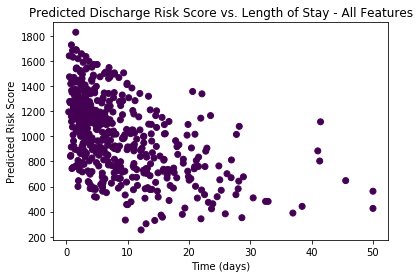

In [35]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

y_pred_scaled = scaler1.fit_transform(y_pred.reshape(-1, 1))
y_test_scaled = scaler2.fit_transform(y_test['Survival_in_days'].reshape(-1, 1))

plt.figure()
# plt.scatter(y_test['Survival_in_days'], y_pred, c=[not i for i in y_test['Status']])
plt.scatter(y_test['Survival_in_days'], y_pred, c=y_test['Status'])
if mort_pred:
    classes = ListedColormap(['Death','Survival'])
    plt.colorbar() # 1 (Death) is yellow, 0 (Survival) is purple
    title = 'Predicted Death Risk Score vs. Survival Length'
elif los_pred:
    title = 'Predicted Discharge Risk Score vs. Length of Stay'
    
if mort_features:
    plt.title(title + ' - Mort Features')
elif los_features:
    plt.title(title + ' - LOS Features')
else:
    plt.title(title + ' - All Features')
plt.xlabel('Time (days)')
plt.ylabel('Predicted Risk Score')